# 5. Natural Language Processing
After having selected videos, downloaded videos and transcribed videos, it is time to process the files and turn them into workable data. We will be engineering several interesting metrics in order to measure formality within our text files aside from the usual metrics connected to textual data and we will be walking through the cleaning and pruning process. 

In [ ]:
# Overall Document Prep:
from pyforest import * # This library quickly imports most of the relevant Data Science libraries
directory = '####'     # Set a working directory

## 5.1 Load the data

In [ ]:
# Read the Data:
Sample_V1 = pd.read_csv(f'{directory}Sample_V1.csv', 
                        sep = ";",
                        index_col=0)
Sample_V1.reset_index(drop=True,inplace=True)

In [ ]:
def txtReader(df, variant='V1'):
    
    text = {'Transcript': []}
    missing = 0

    for i in df['Video.ID']:

        try:

            with open(f'/Volumes/Samsung_T5/Thesis/Text/{variant}/{i}.txt') as t:
                text['Transcript'].append(t.read())

        except(FileNotFoundError):

            text['Transcript'].append('No Data')

            missing = missing + 1

    text = pd.DataFrame(text)
    df = pd.concat([df, text], axis = 1)

    print(f'Missing data for {missing} videos')
    
    return df

In [ ]:
Sample_V1 = txtReader(Sample_V1)

In [ ]:
#Remove duplicates and untranscribables
Sample_V1 = Sample_V1.drop_duplicates('Video.ID')        # Exclude duplicate videos
Sample_V1 = Sample_V1[Sample_V1.Transcript != 'No Data'] # Exclude failed transcripts
# Exclude transcripts shorter than 100 words
Sample_V1 = Sample_V1[Sample_V1['Transcript'].apply(lambda x: len(x.split()) > 100)] 
print(f'{len(Sample_V1)} cases remain')

In [ ]:
# Take Samples:
#Sample_V1['Transcript'][15]

## 5.1 Cleaning

In [ ]:
# Fix duration column, transform it to seconds
import isodate
Sample_V1['duration']    = Sample_V1['duration'].apply(isodate.parse_duration)
Sample_V1['duration']    = Sample_V1['duration'] / np.timedelta64(1, 's')

# Fix published at date, into number of days old
Sample_V1['publishedAt'] = Sample_V1['publishedAt'].apply(isodate.parse_date)

from datetime import date
day_of_collection        = date(2021, 6, 26)
Sample_V1['publishedAt'] = day_of_collection - Sample_V1['publishedAt']
Sample_V1['publishedAt'] = Sample_V1['publishedAt'].dt.days
Sample_V1.rename(columns = {'publishedAt':'days_old'}, inplace=True)

# Remove transcription remenants
Sample_V1['Transcript']  = [re.sub('%HESITATION', '',  t) for t in Sample_V1['Transcript']]

## 5.2 Basic feature engineering

In [ ]:
import spacy
nlp = spacy.load('en')

# Tokenize all of the transcripts
Sample_V1['Document']  = [nlp(x) for x in Sample_V1['Transcript']]

In [ ]:
# Word count
Sample_V1['Word_Count'] = [len(x.split()) for x in Sample_V1['Transcript'].tolist()]

# Character count
Sample_V1['Chr_Count'] = [len(x) for x in Sample_V1['Transcript'].tolist()]

# Sentence count
sent_count = []

for doc in Sample_V1['Document']:
    sent_count.append(len([[token.text for token in sent] for sent in doc.sents]))

Sample_V1['Sentences'] = sent_count

# Average word length
word_len = []

for doc in Sample_V1['Document']:
    try:
        word_len.append(round(sum([len(token) for token in doc])/len(doc),1))
    except:
        word_len.append(0)

Sample_V1['Avg_Word_Length'] = word_len

# Average sentence length
sent_len = []

for doc, numsen in zip(Sample_V1['Document'], Sample_V1['Sentences']):
    try:
        sent_len.append(round(sum([len(sent) for sent in doc.sents])/numsen,1))
    except(ZeroDivisionError):
        sent_len.append(0)

Sample_V1['Avg_Sent_Length'] = sent_len

## 5.3 Processing Transcripts

In [ ]:
# Remove stopwords
Sample_V1['Document_no_stop'] = Sample_V1.Document.apply(lambda text: 
                                                 " ".join(token.text for token in text 
                                                    if not token.is_stop))  
# Lemmatization
lemmas = []

for doc in Sample_V1['Document']:
    lemmas.append(" ".join(token.lemma_ for token in doc))

Sample_V1['Document_lemmatized'] = lemmas

## 5.4 Calculating independent variables

### 5.4.1 F-Score
The F-Score is the first of 5 metrics. The formula reads as follows: 

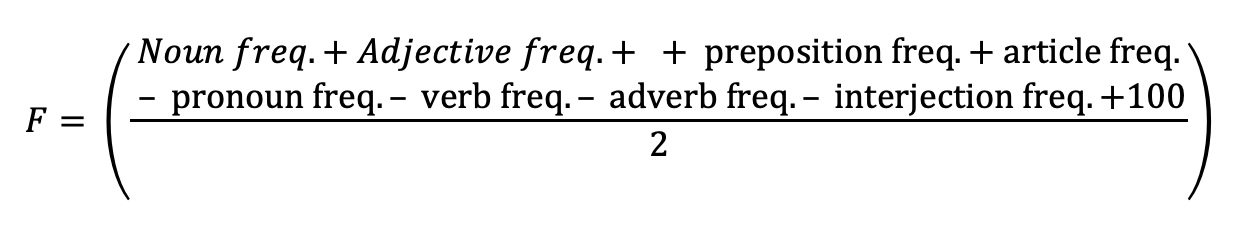

The function below generates the F-Score based on Spacy's POS tagging. It was chosen to normalize the data by dividing it with the total number of tokens as upon further investigation it became clear that the value of the F-Score could be predicted by the number of words in a document. 

In [ ]:
# Might be useful for cleaning the function
POS = {'nouns'        :92,
       'adjectives'   :84,
       'prepositions' :85,  
       'pronouns'     :95,
       'verbs'        :100, 
       'adverbs'      :86,
       'interjections':91}

In [ ]:
def F_Score(df):
    
    # dependencies
    from collections import Counter
    
    F_Scores = []
    
    for doc,tsc in zip(df['Document'], df['Transcript']):
        
        # Retrieve Parts of Speech from SpaCy
        POS_counts = doc.count_by(spacy.attrs.POS)
        
        try:
            nouns = POS_counts[92]
        except(KeyError):
            nouns = 0
        
        try:
            adjectives = POS_counts[84]
        except(KeyError):
            adjectives = 0
        
        try:
            prepositions = POS_counts[85]
        except(KeyError):
            prepositions = 0
        
        # articles need to be retrieved manually
        
        try:
            pronouns = POS_counts[95]
        except:
            pronouns = 0
        
        try:
            verbs = POS_counts[100]
        except(KeyError):
            verbs = 0
        
        try:
            adverbs = POS_counts[86]
        except(KeyError):
            adverbs = 0
        
        try:
            interjections = POS_counts[91]
        except(KeyError):
            interjections = 0

        # Retrieve articles manually
        tsc = tsc.lower()
        freq = Counter(tsc.split())
        articles = freq['an'] + freq['a'] + freq['the']
        
        # Caclulate F-score
        F_Score = (
            (nouns +
             adjectives +
             prepositions +
             articles) -
            pronouns -
            verbs -
            adverbs -
            interjections +
            100
        ) / 2
        
        F_Scores.append(F_Score)
    
    return F_Scores

In [ ]:
Sample_V1['F_Score'] = F_Score(Sample_V1)

pearsonr(Sample_V1['F_Score'], Sample_V1['Word_Count'])

### 5.4.2 Readability Scoring
Readability scoring reflects the ease of reading a text. There are many renditions; however, within this work we follow the Dale-Chall formula, one of the oldest. It is based on a list of 3000 words that were found to be familliar by at least 80 percent of Grade 5 children. 

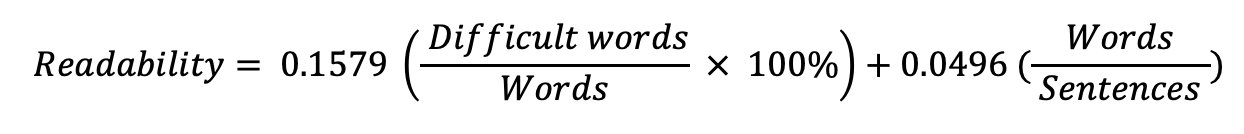

Sources:
- https://readabilityformulas.com/articles/dale-chall-readability-word-list.php
- https://en.wikipedia.org/wiki/Dale%E2%80%93Chall_readability_formula

In [ ]:
def ReadabilityScore(df):
    
    with open(f'{directory}Dale_Chall_Word_list.txt') as t:
                word_list = t.read().splitlines()
    
    ReadabilityScore = []
    
    for tsc,asl in zip(df['Transcript'], df['Avg_Sent_Length']):
    
        easy_words = 0
    
        for word in tsc.split():
            if (word in word_list):
                easy_words = easy_words + 1
            else:
                pass

        total_words = len(tsc.split())
        pdw = ((total_words - easy_words)/total_words)*100
        raw_score = (0.1579*pdw) + (0.0496*asl)

        if (pdw > 5):

            ReadabilityScore.append(raw_score + 3.3665)

        else:

            ReadabilityScore.append(raw_score)
        
    return ReadabilityScore

In [ ]:
Sample_V1['Readability_Score'] = ReadabilityScore(Sample_V1)

### 5.4.3 Clause Parsing
The next few metrics will be requiring an additional step, which is calles clause parsing. We need to be able to count both independent as well as dependent clauses. 

In [ ]:
import stanza
stanza.download('en')          # This downloads the English models for the neural pipeline
stanlp = stanza.Pipeline(lang='en', 
                         processors='tokenize,mwt,pos,lemma,depparse')
def ClauseParsing(df):
    
    clause_count = []
    
    for tsc in df['Transcript']:
        
        doc = stanlp(tsc)
        count = len([word.deprel for sent in doc.sentences for word in sent.words if word.deprel == 'root'])
        clause_count.append(count)
        
        #Progress Report:
        current = df[df['Transcript'] == tsc].index[0] + 1
        every = len(df)
        
        if (current % 50 == 0):

            print(f'{current} out of {every} files have been counted.')
            print(f'We are {((current/every)*100):.1f}% of the way there! \n')
        
        elif(current == len(df)):
            
            print('100% of Transcripts have been parsed.')
    
    return clause_count

In [ ]:
Sample_V1['Clauses'] = ClauseParsing(Sample_V1)

### 5.4.3 Lexical Density
Lexical Density refers to the number of lexical items (nouns, adjectives, verbs or adverbs, basically the most informative parts of speech) as a percentage of the number of clauses within a text, this shows how efficiently information is conveyed. The larger the percentage, the fewer words are used to convey information. 

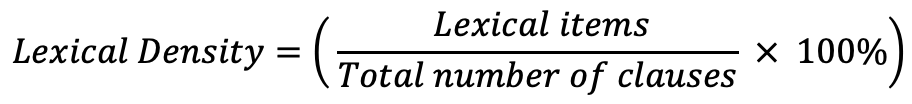

In [ ]:
def LexicalDensity(df):
    
    lexical_density = []
    
    for doc,cc in zip(df['Document'], df['Clauses']):
        
        # Retrieve Parts of Speech from SpaCy
        POS_counts = doc.count_by(spacy.attrs.POS)
        
        try:
            nouns = POS_counts[92]
        except(KeyError):
            nouns = 0
        
        try:
            adjectives = POS_counts[84]
        except(KeyError):
            adjectives = 0
        
        try:
            verbs = POS_counts[100]
        except(KeyError):
            verbs = 0
            
        try:
            adverbs = POS_counts[86]
        except(KeyError):
            adverbs = 0
        
        items = nouns + adjectives + verbs + adverbs
        LD =  (items/cc)
        
        lexical_density.append(LD)
    
    return lexical_density

In [ ]:
Sample_V1['Lexical_Density'] = LexicalDensity(Sample_V1)

### 5.4.4 Mean Lenght Communication Unit
Communication units can be loosely defined as sentences that contain main clauses. The MLCU measure is simply the average length of sentences that convey a main clause.

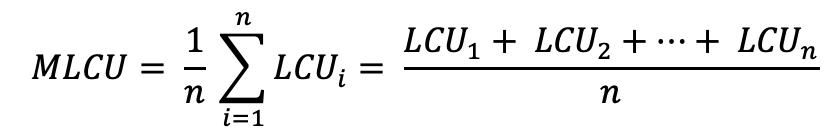

In [ ]:
def MeanLenghtCommunicationUnit(df):
    
    MeanLenghtCommunicationUnit = []
    
    for tsc,cc in zip(df['Transcript'], df['Clauses']):
        
        doc = stanlp(tsc)
        total_cu_len = sum([len(sent.words) for sent in doc.sentences for word in sent.words if word.deprel == 'root'])
        mclu = total_cu_len/cc
        
        MeanLenghtCommunicationUnit.append(round(mclu,3))
    
        #Progress Report:
        current = df[df['Transcript'] == tsc].index[0] + 1
        every = len(df)
        
        if (current % 50 == 0):

            print(f'{current} out of {every} files have been calculated.')
            print(f'We are {((current/every)*100):.1f}% of the way there! \n')
        
        elif(current == len(df)):
            
            print('100% of Transcripts have been assessed.')
    
    return MeanLenghtCommunicationUnit    

In [ ]:
Sample_V1['MCLU'] = MeanLenghtCommunicationUnit(Sample_V1)

### 5.4.5 Clausal Density

In [ ]:
# Unable to retrieve

## 5.5 Output Final DataFrame

In [ ]:
Thesis_Dataset =  Sample_V1.drop(['Transcript', 
                                  'Document',
                                  'Document_no_stop',
                                  'Document_lemmatized'], 
                                 axis = 1)

Thesis_Dataset.to_csv(f'{directory}Thesis_Dataset.csv' , sep = ';')